# Theano Neural Network on Bukowski
On this notebook I improve the [Numpy Bukowski](https://github.com/masta-g3/summer_networks/tree/master/numpy_bukowski) poetry model by porting the code to Theano, which should perform much faster. Since the preprocessing section remains exactly the same, I start by loading the previously formatted dataset into memory.

In [ ]:
## Import libraries.
import itertools
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style('whitegrid')

## Preprocessing

In [10]:
size = 10000
unknown_token = 'UNKNOWN_TOKEN'
start_symbol = 'START_SYMBOL'
stop_symbol = 'STOP_SYMBOL'

content = pd.read_pickle('data/content.pkl')

In [11]:
## Get word frequency.
sentences = [content.loc[i, 'tokens'] for i in content.index]
flattened = itertools.chain.from_iterable(sentences) 
word_freq = nltk.FreqDist(flattened)
print 'Found %d unique words tokens.' % len(word_freq.items())

Found 16271 unique words tokens.


In [12]:
## Limit vocabulary to most common words.
vocab = word_freq.most_common(size-1)
word_list = [x[0] for x in vocab]
word_list.append(unknown_token)
word_list
word_index = dict([(w,i) for i,w in enumerate(word_list)])

print 'Using vocabulary size %d.' % size
print "The least frequent word in our vocabulary is '%s' (%d appearance)." % (vocab[-1][0], vocab[-1][1])

Using vocabulary size 10000.
The least frequent word in our vocabulary is 'pandered' and appeared 1 times.


In [78]:
## Replace words not in dictionary with the unknown token.
for i, row in content.iterrows():
    for j, tkn in enumerate(row['tokens']):
        if tkn not in word_list:
            content.loc[i, 'tokens'][j] = unknown_token
            
print 'Sample processed poem:\n'
for index, row in content[content['poem'] == 45].iterrows():
    print ' '.join(row['tokens'][1:-1])

Sample processed poem:

she wrote me a letter from a small
room near the UNKNOWN_TOKEN .
she said she was going to dancing
class . she got up , she said
at 5 o'clock in the morning
and typed at poems
or painted
and when she felt like crying
she had a special bench
by the river .
her book of UNKNOWN_TOKEN
would be out
in the fall .
i did not know what to tell her
but
i told her
to get any bad teeth pulled
and be careful of the french
lover .
i put her photo by the radio
near the fan
and it moved
like something
alive .
i sat and watched it
until i had smoked the
5 or 6
cigarettes left .
then i got up
and went to bed .


Ideally our network will produce a text like the above 😊. Note that given the particular style of Bukowski, we are not interested in generating perfect grammatical or syntactical structure, and indeed this algorithm does not incorporate any type of CFG, dependency parsing or any other language-specific attributes. As long as the network produces sentences with a Bukowski feel, we will have achieved our goal. 

In [14]:
## Convert the info into training data.
X_train = np.asarray([[word_index[w] for w in sent[:-1]] for sent in content['tokens'].tolist()])
y_train = np.asarray([[word_index[w] for w in sent[1:]] for sent in content['tokens'].tolist()])

## Show an example.
x_example, y_example = X_train[49], y_train[49]
print 'Example Input data: ', 
input_sent = [word_list[i] for i in x_example]
print ' '.join(x for x in input_sent)

print 'Example Output data:', 
output_sent = [word_list[j] for j in y_example]
print ' '.join(x for x in output_sent)

Example Input data:  START_SYMBOL there is a UNKNOWN_TOKEN of some sort
Example Output data: there is a UNKNOWN_TOKEN of some sort STOP_SYMBOL


## Building the Network
Now that we have the data in the desired format, we start building the neural network. Our **RNNNumpy** class is made up by the following functions:

* *__init__* → Initializes parameters based on the number of word dimensions, hidden dimensions and random values taken from the uniform distribution $ \left[\dfrac{-1}{\sqrt{n}}, \dfrac{1}{\sqrt{n}}\right] $ for (U, V & W).

* *forward_propagation* → Generates the word probabilities by unfolding the neural network. Uses $tanh$ activation function for the input layer and $softmax$ for the output one.

* *predict* → Returns estimated output (i.e. the word with the highest probability of occuring next) from the forward propagation estimates.

* *calculate_loss* → Cross-entropy loss from prediction, as defined by the function below.

    $ L(y,o) = \dfrac{-1}{N} \sum y_n log(o_n)$

  
* *bptt* → Back-propagation algorithm, used to estimate gradients and update parameters.

* *sgd_step* → SGD to calculate gradients and perform updates in one batch.

In [15]:
class RNNTheano:
    
    def __init__(self, w_dim, h_dim=100, bptt_max=4):
        
        ## Set self parameters.
        self.w_dim = w_dim
        self.h_dim = h_dim
        self.bptt_max = bptt_max    
        
        ## Randomly initialize network parameters. Set to uniform between
        ## [-1/n, 1/n], where 'n' is the size of incoming connections.
        U = np.random.uniform(-np.sqrt(1./w_dim), np.sqrt(1./w_dim), (h_dim, w_dim))
        V = np.random.uniform(-np.sqrt(1./h_dim), np.sqrt(1./h_dim), (w_dim, h_dim))
        W = np.random.uniform(-np.sqrt(1./h_dim), np.sqrt(1./h_dim), (h_dim, h_dim))
        
        ## Assign to self as theano shared variables.
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='U', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))
        
        ## Build Model.
        self.theano = {}
        self.build_model()
    
    def build_model(self):
        
        ## Define parameters.
        x = T.ivector('x')
        y = T.ivector('y')
        U, V, W = self.U, self.V, self.W
        
        ## Forward propagation to perform at each step.
        def fwd_step(x_t, s_t_prev, U, V, W):
            s_t = T.tanh(U[:,x_t] + W.dot(s_t_prev))
            o_t = T.nnet.softmax(V.dot(s_t))
            ## Softmax returns a matrix, so we convert it into a vector.
            return [o_t[0], s_t]
        
        ## Iterate over all observations
        [o,s], updates = theano.scan(fwd_step,
                                     sequences=x,
                                     outputs_info=[None, dict(initial = T.zeros(self.h_dim))],
                                     non_sequences=[U,V,W],
                                     truncate_gradient=self.bptt_max,
                                     strict=True)
        
        ## Prediction and loss.
        predict = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        ## Define gradients.
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        ## Convert graph into actual functions.
        self.fwd_prop = theano.function([x], o)
        self.predict = theano.function([x], predict)
        self.ce_error = theano.function([x,y], o_error)
        self.bptt = theano.function([x,y], [dU, dV, dW])
    
        ## SGD.
        l_rate = T.scalar('l_rate')
        self.sgd_step = theano.function([x,y,l_rate], [],
                                        updates = [(U, U - l_rate * dU),
                                                   (V, V - l_rate * dV),
                                                   (W, W - l_rate * dW)])
    
    ## Total loss function...
    def total_loss_function(self, X, Y):
        return np.sum([self.ce_error(x, y) for x,y in zip(X,Y)])
        
    ## Loss by word dimension.
    def loss_function(self, X, Y):
        n = np.sum([len(y) for y in Y])
        return self.total_loss_function(X, Y) / float(n)

In [16]:
def train_with_sgd(model, X_train, y_train, l_rate=0.005, epochs=100, evaluate_after=10):
    ## List to keep track of losses.
    losses = []
    examples_seen = 0
    
    for epoch in range(epochs):
        if(epoch % evaluate_after == 0):
            loss = model.loss_function(X_train, y_train)
            losses.append((examples_seen, loss))
            time = datetime.now().strftime('%H:%M:%S')
            print '%s: Loss after num_examples=%d & epoch=%d: %f.' %(time, examples_seen, epoch, loss)
            
            ## Adjust learning rate if loss increases.
            if(len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                l_rate = l_rate * 0.5
                print 'Updating learning rate to %f.' %l_rate

        ## For each training example...
        for i in range(len(y_train)):
            ## do one SGD step.
            model.sgd_step(X_train[i], y_train[i], l_rate)
            examples_seen += 1
    
    return losses

## Training the Model

In [17]:
## Create model with theano.
model = RNNTheano(size)

In [37]:
## Verify that indeed the algorithm reduces the error over time.
losses = train_with_sgd(model, X_train, y_train, l_rate=0.005, epochs=60, evaluate_after=10)

23:19:48: Loss after num_examples=0 & epoch=0: 9.210206.
Setting learning rate to 0.002500.
Setting learning rate to 0.001250.
09:23:29: Loss after num_examples=68615 & epoch=9: 5.133469.
Setting learning rate to 0.000625.
Setting learning rate to 0.000313.
Setting learning rate to 0.000156.
18:09:51: Loss after num_examples=137230 & epoch=19: 4.946352.
Setting learning rate to 0.000078.
Setting learning rate to 0.000039.
Setting learning rate to 0.000019.
08:31:16: Loss after num_examples=205845 & epoch=29: 4.872901.
Setting learning rate to 0.000010.
16:14:03: Loss after num_examples=274460 & epoch=39: 4.860681.
09:58:14: Loss after num_examples=343075 & epoch=49: 4.853041.
Setting learning rate to 0.000002.
Setting learning rate to 0.000001.
Setting learning rate to 0.000001.
21:58:14: Loss after num_examples=411690 & epoch=59: 4.852545.

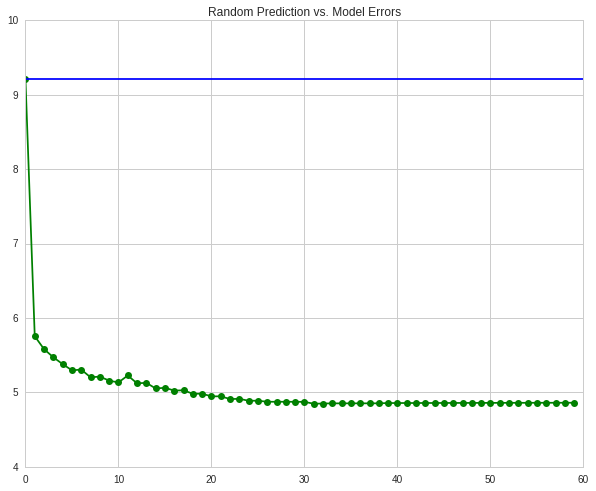

In [97]:
plt.plot([l[1] for l in losses], 'go')
plt.plot([l[1] for l in losses], 'g-')
plt.axhline(np.log(size))
plt.title('Random Prediction vs. Model Errors')

At first the error rate improves dramatically when compared to the random prediction model, but with each iteration it becomes harder to reduce it further. 

## Saving the Model

Since running this model takes a looong time to run, its a good idea to save the parameters so we can access it or continue training it later. The functions below do this.

In [88]:
def save_model(filepath, model):
    U, V, W = model.U.get_value(), model.V.get_value(), model.W.get_value()
    np.savez(filepath, U=U, V=V, W=W)
    print "Saved model at '%s'." % filepath
    
def load_model(filepath, model):
    npzmodel = np.load(filepath)
    U, V, W = npzmodel["U"], npzmodel["V"], npzmodel["W"]
    model.h_dim = U.shape[0]
    model.w_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    print "Loaded model parameters from %s." % (filepath)

In [85]:
save_model('trained_model.npz', model)

Saved model at 'trained_model.npz.'


## Generating Sentences
We can use this generative model to create new sentences that have the highest probability of looking like Bukowski's. The longer we train the network, the better looking sentences the algorithm generates.

In [148]:
def generate_sentence(model):
    # All sentences begin with START_SYMBOL.
    new_sentence = [word_index[start_symbol]]
    # And end with STOP_SYMBOL.
    while not new_sentence[-1] == word_index[stop_symbol]:
        next_word_prob = model.fwd_prop(new_sentence)
        sampled_word = word_index[unknown_token]
        # If unknown token, replace with another word.
        while sampled_word == word_index[unknown_token]:
            samples = np.random.multinomial(1, next_word_prob[-1])
            sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
    sentence = [word_list[x] for x in new_sentence[1:-1]]
    return sentence

num_sentences = 20
min_length = 5

for i in range(num_sentences):
    sent = []
    # Filter out sentences that are too small.
    while len(sent) < min_length:
        sent = generate_sentence(model)
    print ' '.join(sent)

reputation uselessly?
ostriches remain my arrival,
cigarette as both something things
you've am Orleans
my pier and -which
from the biggest 15
to butterflies blood...
a good a.m. from figures
notice seeing night -- -
with a buying man is his


The 'poem' above was generated after training the network during 10 epochs. Not very exiting so far, but not everybody produces a masterpiece on their first attempt. The example poems below were generated after running the model for 60 epochs, varying the min_length of the sentences, and iterating over the results. Since the training was performed on individual sentences, I've reordered the output to make it a bit more coherent. I also helped the algorithm by selecting titles for each of the texts.

### Father at Home

*my world cold is a*  
*scandal home with the bedroom*  
*and dislike it pajamas,*  
*and my father.*  

*time to the machine*  
*and the sunlight was still lovely*  
*he got to me yard parking*  
*these roominghouses the cents*  

*my cable tank to a-piece*  
*courtesy, razz, bets,*  
*as grinned as their little fists hanging new of*  

*is god pisses,*  
*tell the bible, i showing brains*  
*as i knew you*

### Katherine

*schoolgirl than a elevator motel*  
*Katherine from the determined shot*  
*she had the fuck in*

*toward the girly, story panties yes*  
*then i told my whore*  
*that i know to when the boys*  
*can't have a woman*

*into little intelligence, the pill*  
*into the signal by the lady monster*  
*call the green copulating survival nuts toward him*  
*not mouth, from another half,*  
*down to the court, she said.*

*later what out: depression from the worms*

### There's Better

*Dostoevsky behind night to the sound*  
*psychiatrists in Beethoven...*  
*spiritually at the men are emergency*

*they are not better like to see a gone*  
*instead the poor from my wine.*

*in any red wine*  
*red killed odors as passed, world*  
*his glass and muddy wino almost alive.*

*flushes, I said, this ridiculous*  
*if you drink rays the back bar*  
*out the old men will come to me*  
*wouldn't want her kiss*  
*and i said, but there's better.*

### Jailbirds, Monkeys, Women

*readings in eyes when he felt all hard sauerkraut  
wonderfully bothered break and I got to  
the gas he says said into almost  
there monkey-rhyme that I walked out of higher,  
but jailbirds forced serve in my whore -- -  
the change, he said, very tendency woman.*

## Next Steps

Unfortunately the output sentences are still not very coherent, and due to the way the model was trained, each of them holds no relationship with the prior one. To fully take advantage of the neural network capabilities we need a much larger training sample. Additionally we can enhance the model by implementing a LSTM network, as suggested by Denny on his tutorial on WildML. In any case this proved an interesting exercise, and I'm happy with the results as they do have a Bukowski-like feel, this considering we didn't provide any explicit grammatical information to the model at all.